In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

customers = pd.read_csv('/content/Customers.csv')
products = pd.read_csv('/content/Products.csv')
transactions = pd.read_csv('/content/Transactions.csv')

Davies-Bouldin Index: 0.9945199834056279


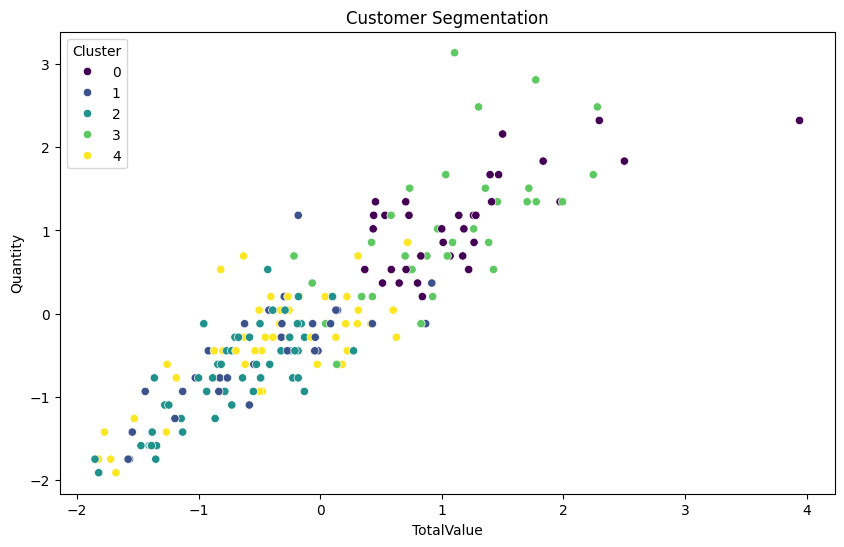

Number of clusters: 5
Davies-Bouldin Index: 0.9945199834056279


In [16]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import numpy as np

merged_df = pd.merge(transactions, customers, on='CustomerID', how='left')

merged_df['TransactionDate'] = pd.to_datetime(merged_df['TransactionDate'])
merged_df['SignupDate'] = pd.to_datetime(merged_df['SignupDate'])
merged_df['DaysSinceSignup'] = (merged_df['TransactionDate'] - merged_df['SignupDate']).dt.days
merged_df['Month'] = merged_df['TransactionDate'].dt.month
merged_df['TotalValue'] = pd.to_numeric(merged_df['TotalValue'], errors='coerce')
merged_df.dropna(subset=['TotalValue'], inplace=True)

customer_transactions = merged_df.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'TotalValue': 'sum',
    'DaysSinceSignup': 'mean',
    'Month': lambda x: x.mode()[0] if not x.mode().empty else np.nan
})

customer_transactions.fillna(customer_transactions.mean(), inplace=True)

le = LabelEncoder()
customer_transactions['Region'] = le.fit_transform(customers.set_index('CustomerID').loc[customer_transactions.index, 'Region'])

scaler = StandardScaler()
numerical_cols = ['Quantity', 'TotalValue', 'DaysSinceSignup', 'Month']
customer_transactions[numerical_cols] = scaler.fit_transform(customer_transactions[numerical_cols])

kmeans = KMeans(n_clusters=5, random_state=42)
customer_transactions['Cluster'] = kmeans.fit_predict(customer_transactions)

db_index = davies_bouldin_score(customer_transactions, customer_transactions['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")

plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalValue', y='Quantity', hue='Cluster', data=customer_transactions, palette='viridis')
plt.title('Customer Segmentation')
plt.show()

print(f"Number of clusters: {kmeans.n_clusters}")
print(f"Davies-Bouldin Index: {db_index}")

In [20]:
import plotly.express as px

fig = px.scatter_3d(customer_transactions, x='TotalValue', y='Quantity', z='DaysSinceSignup', color='Cluster', opacity=0.7)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [22]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score
silhouette_avg = silhouette_score(customer_transactions, customer_transactions['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")

ch_score = calinski_harabasz_score(customer_transactions, customer_transactions['Cluster'])
print(f"Calinski-Harabasz Index: {ch_score}")

Silhouette Score: 0.3767926609906507
Calinski-Harabasz Index: 95.54246224860366
